# Data Preprocessing
# *Weakly Supervised Learning for Industrial Optical Inspection*

Data could be found at http://resources.mpi-inf.mpg.de/conferences/dagm/2007/prizes.html, to download the 12 zip-files we type
```
wget http://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class{1..6}.zip
wget http://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class{1..6}_def.zip
```

In [19]:
# author: Zilong Zhao

In [3]:
import os
import glob
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import math
from tqdm import tqdm
import random
import shutil

In [4]:
raw_data_dir = '/opt/Daten/DAGM/Raw_data/'

In [15]:
def check_barplot(data_dir):
    class1=[]
    class2=[]
    class3=[]
    class4=[]
    class5=[]
    class6=[]
    class1_def=[]
    class2_def=[]
    class3_def=[]
    class4_def=[]
    class5_def=[]
    class6_def=[]

    for filename in glob.iglob(data_dir + '**/*.*', recursive=True):
        if 'Class1/' in filename:
            class1.append(filename)
        elif 'Class2/' in filename:
            class2.append(filename)
        elif 'Class3/' in filename:
            class3.append(filename)
        elif 'Class4/' in filename:
            class4.append(filename)
        elif 'Class5/' in filename:
            class5.append(filename)
        elif 'Class6/' in filename:
            class6.append(filename)
        elif 'Class1_def/' in filename:
            class1_def.append(filename)
        elif 'Class2_def/' in filename:
            class2_def.append(filename)
        elif 'Class3_def/' in filename:
            class3_def.append(filename)
        elif 'Class4_def/' in filename:
            class4_def.append(filename)
        elif 'Class5_def/' in filename:
            class5_def.append(filename)
        else:
            class6_def.append(filename)
    class_name=sorted(['Class' + str(n) for n in range(1, 7)] + ['Class' + str(n) + '_def' for n in range(1,7)])
    class_count=[len(class1), len(class1_def), 
                 len(class2), len(class2_def),
                 len(class3), len(class3_def),
                 len(class4), len(class4_def),
                 len(class5), len(class5_def),
                 len(class6), len(class6_def)]
    plt.figure(figsize = (12,6))
    sns.barplot(class_name, class_count, alpha = 0.9)
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Class name', fontsize =12)
    plt.ylabel('Counts', fontsize = 12)
    plt.show()

# Let's check how many pics we have for each class

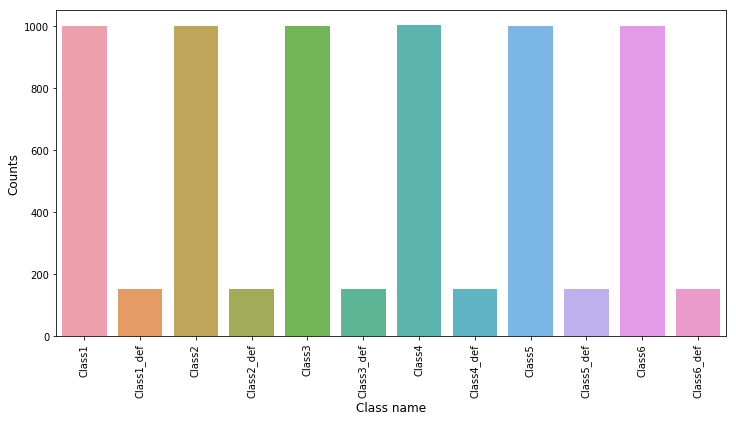

In [16]:
check_barplot(data_dir=raw_data_dir)

The barplot shows an extream unbalance in the classes with defectness. To prevent overfitting, we need to do some data augmentation job.

# Data augmentation
Using Keras, we can easily rotate, flip, shift the image with
```
keras.preprocessing.image.ImageDataGenerator()
```

In [118]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')


target_class_count = 1200

dest_train_dir='/opt/Daten/DAGM/train_data/'

def tqdm_enumerate(iter):
    i = 0
    for y in tqdm(iter):
        yield i, y
        i += 1

for j, c in tqdm_enumerate(class_count):
    dest_lab_dir=os.path.join(dest_train_dir, class_name[j])
    src_lab_dir=os.path.join(raw_data_dir, class_name[j])
    
    
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    random_file=random.choices(population=[x for x in os.listdir(src_lab_dir) if '.png' in x], k=target_class_count-c)
    for file in random_file:
        img=load_img(os.path.join(src_lab_dir,file))
        x=img_to_array(img)
        x=x.reshape((1,) + x.shape)
        for batch in datagen.flow(x, batch_size=1, save_to_dir=dest_lab_dir, save_format='jpg', save_prefix=file):
            if target_class_count - len(os.listdir(dest_lab_dir)) > 0:
                break
                    
            












  0%|          | 0/12 [00:00<?, ?it/s]










  8%|▊         | 1/12 [00:08<01:32,  8.45s/it]










 17%|█▋        | 2/12 [00:53<03:14, 19.42s/it]










 25%|██▌       | 3/12 [01:01<02:24, 16.07s/it]










 33%|███▎      | 4/12 [01:45<03:16, 24.52s/it]










 42%|████▏     | 5/12 [01:54<02:17, 19.60s/it]










 50%|█████     | 6/12 [02:37<02:39, 26.61s/it]










 58%|█████▊    | 7/12 [02:45<01:45, 21.03s/it]










 67%|██████▋   | 8/12 [03:27<01:49, 27.45s/it]










 75%|███████▌  | 9/12 [03:35<01:04, 21.64s/it]










 83%|████████▎ | 10/12 [04:18<00:56, 28.05s/it]










 92%|█████████▏| 11/12 [04:27<00:22, 22.24s/it]










100%|██████████| 12/12 [05:12<00:00, 29.05s/it]












In [120]:
!scp -r /opt/Daten/DAGM/Raw_data/. /opt/Daten/DAGM/train_data/.

In [121]:
dest_test_dir='/opt/Daten/DAGM/test_data/'

for d in os.listdir(dest_train_dir):
    files=os.listdir(os.path.join(dest_train_dir, d))
    dest_lab_dir=os.path.join(dest_test_dir, d)
    if not os.path.exists(dest_lab_dir):
        os.makedirs(dest_lab_dir)
    random_file=random.sample(population=[x for x in files], k=300)
    for rf in random_file:
        shutil.move(dest_train_dir+d+'/'+rf, dest_test_dir+d+'/'+rf)

# Now let's check again

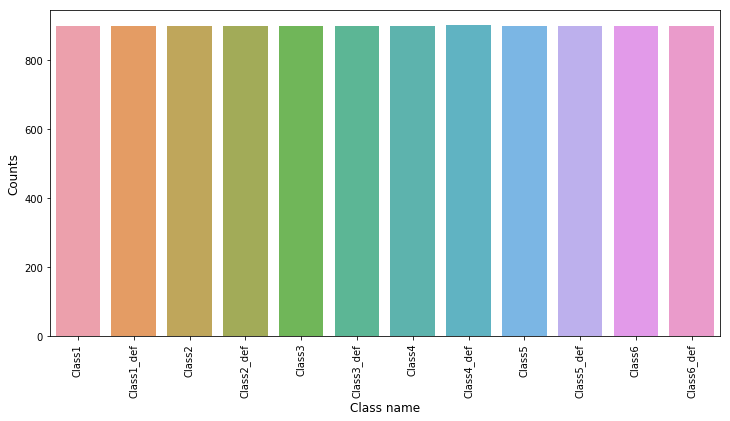

In [17]:
# the training data
check_barplot(data_dir='/opt/Daten/DAGM/train_data/')

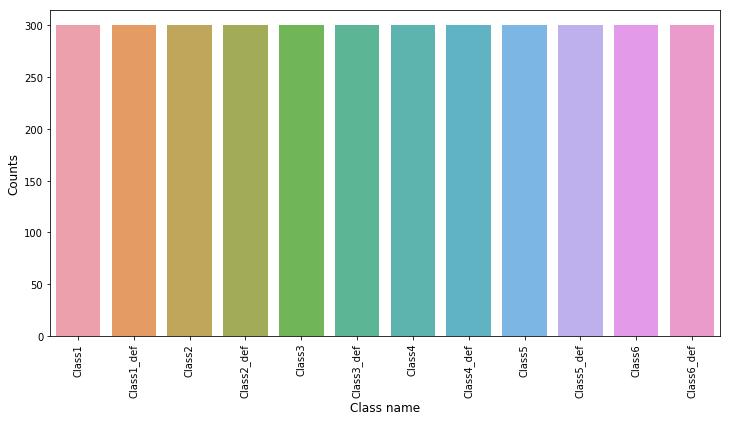

In [18]:
# the test data
check_barplot(data_dir='/opt/Daten/DAGM/test_data/')

After augmenting the data, we got balanced training- and test datasets. Next step, we will use the **retrain.py** script, which is officially provided by TensorFlow and could be downloaded with
```
wget https://github.com/tensorflow/hub/raw/master/examples/image_retraining/retrain.py
```

To start it, simply type
```
python retrain.py --image_dir /opt/Daten/DAGM/train_data
```
As a default setting, it will download the **Inception V3** model from [TensorFlow Hub](https://tfhub.dev/) and train with our pre-processed training data automatically.  